In [48]:
# run model for predict f1 races
#imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, mean_squared_error

In [49]:
import optuna
print(optuna.__version__)

4.5.0


In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [51]:
# odczyt w pliku danych thesis_f1_final_model.csv
data = pd.read_csv('../../datasets/thesis_final_model_f1_data.csv')
data.head()

,driver_number,broadcast_name,country_code_x,year,session_name,date_start,time_start,date_end,time_end,gmt_offset,...,num_yellow_flags,num_double_yellow_flags,penalty_seconds,air_temp_mean,track_temp_mean,humidity_mean,pressure_mean,rainfall_max,wind_speed_mean,final_position
0,1,M VERSTAPPEN,NED,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,2
1,2,L SARGEANT,USA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,16
2,4,L NORRIS,GBR,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,17
3,10,P GASLY,FRA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,9
4,11,S PEREZ,MEX,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,1


In [52]:
# after baku 2145, 31
data.shape

(2154, 31)

In [53]:
X = data.drop(columns=['final_position'])
y = data['final_position']

In [54]:
X.head()

,driver_number,broadcast_name,country_code_x,year,session_name,date_start,time_start,date_end,time_end,gmt_offset,...,num_safety_car_deployed,num_yellow_flags,num_double_yellow_flags,penalty_seconds,air_temp_mean,track_temp_mean,humidity_mean,pressure_mean,rainfall_max,wind_speed_mean
0,1,M VERSTAPPEN,NED,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
1,2,L SARGEANT,USA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
2,4,L NORRIS,GBR,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
3,10,P GASLY,FRA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
4,11,S PEREZ,MEX,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297


In [55]:
y.head

<bound method NDFrame.head of 0        2
1       16
2       17
3        9
4        1
        ..
2149     3
2150     1
2151     1
2152    19
2153    19
Name: final_position, Length: 2154, dtype: int64>

In [56]:
def categorize_position(pos):
    if pos == 1:
        return 'winner'
    elif pos in [2, 3]:
        return 'top3'
    elif 4 <= pos <= 10:
        return 'points'
    else:
        return 'no_points'

In [57]:
# y to categorize final position
y = y.apply(categorize_position)
y.head()


0         top3
1    no_points
2    no_points
3       points
4       winner
Name: final_position, dtype: object

In [58]:
print("Unikalne kategorie przed kodowaniem:", y.unique())

Unikalne kategorie przed kodowaniem: ['top3' 'no_points' 'points' 'winner']


In [59]:
#change name final_position to final_position_category
y.rename('final_position_category', inplace=True)

0            top3
1       no_points
2       no_points
3          points
4          winner
          ...    
2149         top3
2150       winner
2151       winner
2152    no_points
2153    no_points
Name: final_position_category, Length: 2154, dtype: object

In [60]:
# wyswitel informacje o zbiorze danych
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

#wyswietl cechy
print("Features in X:", X.columns.tolist())
# wyswietl unikalne kategorie pozycji
print("Unique position categories in y:", y.unique())
print(X.dtypes)

Shape of X: (2154, 30)
Shape of y: (2154,)
Features in X: ['driver_number', 'broadcast_name', 'country_code_x', 'year', 'session_name', 'date_start', 'time_start', 'date_end', 'time_end', 'gmt_offset', 'starting_position', 'wins_before', 'pit_stops_count', 'avg_pit_stop_duration', 'qualifying_position_y', 'num_stints', 'used_soft', 'used_medium', 'used_hard', 'num_red_flags', 'num_safety_car_deployed', 'num_yellow_flags', 'num_double_yellow_flags', 'penalty_seconds', 'air_temp_mean', 'track_temp_mean', 'humidity_mean', 'pressure_mean', 'rainfall_max', 'wind_speed_mean']
Unique position categories in y: ['top3' 'no_points' 'points' 'winner']
driver_number                int64
broadcast_name              object
country_code_x              object
year                         int64
session_name                object
date_start                  object
time_start                  object
date_end                    object
time_end                    object
gmt_offset                  object
s

In [61]:
# encode data in X and scale it
from sklearn.preprocessing import LabelEncoder, StandardScaler

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])



In [62]:
print("Kolejność klas (LabelEncoder):", le.classes_)

Kolejność klas (LabelEncoder): ['-03:00:00' '-04:00:00' '-05:00:00' '-06:00:00' '-08:00:00' '01:00:00'
 '02:00:00' '03:00:00' '04:00:00' '08:00:00' '09:00:00' '10:00:00'
 '11:00:00']


In [63]:
# scale data with StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [64]:
#split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [66]:
# compute specificity   
def compute_specificity(conf_mat):
    specificity = []
    for i in range(conf_mat.shape[0]):
        TP = conf_mat[i, i]
        FP = conf_mat[:, i].sum() - TP
        FN = conf_mat[i, :].sum() - TP
        TN = conf_mat.sum() - (TP + FP + FN)
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity.append(spec)
    return specificity

In [67]:
# hyperparameter tuning with Optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
def objective(trial, kfolds, X_train, y_train, X_valid, y_valid):
    # hyperparameters to tune

    # random forest
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 150)
    rf_max_depth = trial.suggest_int("rf_max_depth", 3, 15)

    # gradient boosting
    gb_n_estimators = trial.suggest_int("gb_n_estimators", 50, 150)
    gb_learning_rate = trial.suggest_float("gb_learning_rate", 0.01, 0.3)
    gb_max_depth = trial.suggest_int("gb_max_depth", 2, 10)

    # SVM
    svm_C = trial.suggest_float("svm_C", 0.1, 10.0, log=True)
    svm_kernel = trial.suggest_categorical("svm_kernel", ["linear", "rbf"])

    # models to ensemble
    clf_rf = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                    max_depth=rf_max_depth, 
                                    random_state=42)
    clf_gb = GradientBoostingClassifier(n_estimators=gb_n_estimators, 
                                        learning_rate=gb_learning_rate,
                                        max_depth=gb_max_depth, 
                                        random_state=42)
    
    clf_svm = SVC(C=svm_C, 
                  kernel=svm_kernel, 
                  probability=True, 
                  random_state=42)


    # ensemble model 
    ensemble = VotingClassifier(
        estimators=[('rf', clf_rf), ('gb', clf_gb), ('svm', clf_svm)],
        voting='soft'
    )

    le = LabelEncoder()
    le.fit(y_train)  # lub y_valid, ważne by to były kategorie tekstowe

    # encode labels using the fitted label encoder 'le'
    y_train_enc = le.transform(y_train)
    y_valid_enc = le.transform(y_valid)

    class_labels = le.classes_

    # cross-validation setup
    kf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    acc_list, prec_list, rec_list, f1_list, spec_list = [], [], [], [], []
    mse_list, rmse_list, logloss_list = [], [], []
    
    # PR-AUC lists
    pr_auc_macro_list, pr_auc_weighted_list = [], []

    # new metrics lists
    prec_macro_list, prec_weighted_list = [], []
    rec_macro_list, rec_weighted_list = [], []
    f1_macro_list, f1_weighted_list = [], []

    # globally summed confusion matrix
    conf_mat_sum = np.zeros((len(np.unique(y_train_enc)), len(np.unique(y_train_enc))), dtype=int)

    # cross-validation loop
    for train_index, test_index in kf.split(X_train, y_train_enc):
        X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_te = y_train_enc[train_index], y_train_enc[test_index]

        ensemble.fit(X_tr, y_tr)
        y_pred_cv = ensemble.predict(X_te)
        y_proba_cv = ensemble.predict_proba(X_te)

        conf_mat_cv = confusion_matrix(y_te, y_pred_cv)
        conf_mat_sum += conf_mat_cv  # each fold summed to global confusion matrix

        acc_list.append(accuracy_score(y_te, y_pred_cv))
        prec_list.append(precision_score(y_te, y_pred_cv, average="micro", zero_division=0))
        rec_list.append(recall_score(y_te, y_pred_cv, average="micro", zero_division=0))
        f1_list.append(f1_score(y_te, y_pred_cv, average="micro", zero_division=0))
        auc_list = []

        # new metrics calculations
        prec_macro_list.append(precision_score(y_te, y_pred_cv, average="macro", zero_division=0))
        prec_weighted_list.append(precision_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        rec_macro_list.append(recall_score(y_te, y_pred_cv, average="macro", zero_division=0))
        rec_weighted_list.append(recall_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        f1_macro_list.append(f1_score(y_te, y_pred_cv, average="macro", zero_division=0))
        f1_weighted_list.append(f1_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        spec_cv = np.mean(compute_specificity(conf_mat_cv))
        spec_list.append(spec_cv)

        mse_list.append(mean_squared_error(y_te, y_pred_cv))
        rmse_list.append(np.sqrt(mse_list[-1]))
        logloss_list.append(log_loss(y_te, y_proba_cv))

        # PR-AUC calculations
        pr_auc_macro_list.append(average_precision_score(y_te, y_proba_cv, average="macro"))
        pr_auc_weighted_list.append(average_precision_score(y_te, y_proba_cv, average="weighted"))

        spec_cv = np.mean(compute_specificity(conf_mat_cv))
        spec_list.append(spec_cv)

        mse_list.append(mean_squared_error(y_te, y_pred_cv))
        rmse_list.append(np.sqrt(mse_list[-1]))
        logloss_list.append(log_loss(y_te, y_proba_cv))

        # ROC-AUC for multiclass (one-vs-rest)
        try:
            auc_ovr = roc_auc_score(y_te, y_proba_cv, multi_class='ovr', average='macro')
            auc_list.append(auc_ovr)
        except ValueError:
            auc_list.append(0.5)

    # average and std of metrics across folds
    acc, acc_std = np.mean(acc_list), np.std(acc_list, ddof=0)
    prec, prec_std = np.mean(prec_list), np.std(prec_list, ddof=0)
    rec, rec_std = np.mean(rec_list), np.std(rec_list, ddof=0)
    f1, f1_std = np.mean(f1_list), np.std(f1_list, ddof=0)
    spec, spec_std = np.mean(spec_list), np.std(spec_list, ddof=0)

    mse, mse_std = np.mean(mse_list), np.std(mse_list, ddof=0)
    rmse, rmse_std = np.mean(rmse_list), np.std(rmse_list, ddof=0)
    logloss, logloss_std = np.mean(logloss_list), np.std(logloss_list, ddof=0)

    # PR-AUC averages and stds
    pr_auc_macro, pr_auc_macro_std = np.mean(pr_auc_macro_list), np.std(pr_auc_macro_list, ddof=0)
    pr_auc_weighted, pr_auc_weighted_std = np.mean(pr_auc_weighted_list), np.std(pr_auc_weighted_list, ddof=0)

    # new metrics averages and stds
    prec_macro, prec_macro_std = np.mean(prec_macro_list), np.std(prec_macro_list, ddof=0)
    prec_weighted, prec_weighted_std = np.mean(prec_weighted_list), np.std(prec_weighted_list, ddof=0)

    rec_macro, rec_macro_std = np.mean(rec_macro_list), np.std(rec_macro_list, ddof=0)
    rec_weighted, rec_weighted_std = np.mean(rec_weighted_list), np.std(rec_weighted_list, ddof=0)

    f1_macro, f1_macro_std = np.mean(f1_macro_list), np.std(f1_macro_list, ddof=0)
    f1_weighted, f1_weighted_std = np.mean(f1_weighted_list), np.std(f1_weighted_list, ddof=0)


    # set metrics to return 
    trial.set_user_attr("accuracy", acc)
    trial.set_user_attr("accuracy_std", acc_std)
    trial.set_user_attr("precision", prec)
    trial.set_user_attr("precision_std", prec_std)
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("recall_std", rec_std)
    trial.set_user_attr("f1_score", f1)
    trial.set_user_attr("f1_std", f1_std)
    trial.set_user_attr("specificity_avg", spec)
    trial.set_user_attr("specificity_std", spec_std)

    trial.set_user_attr("mse", mse)
    trial.set_user_attr("mse_std", mse_std)
    trial.set_user_attr("rmse", rmse)
    trial.set_user_attr("rmse_std", rmse_std)
    trial.set_user_attr("logloss", logloss)
    trial.set_user_attr("logloss_std", logloss_std)

    # set new metrics to return
    trial.set_user_attr("precision_macro", prec_macro)
    trial.set_user_attr("precision_macro_std", prec_macro_std)

    trial.set_user_attr("recall_macro", rec_macro)
    trial.set_user_attr("recall_macro_std", rec_macro_std)

    trial.set_user_attr("f1_macro", f1_macro)
    trial.set_user_attr("f1_macro_std", f1_macro_std)

    # save confusion matrix
    trial.set_user_attr("confusion_matrix", conf_mat_sum.tolist())

    trial.set_user_attr("class_labels", class_labels)

    # PR-AUC attributes
    trial.set_user_attr("pr_auc_macro", pr_auc_macro)
    trial.set_user_attr("pr_auc_macro_std", pr_auc_macro_std)
    trial.set_user_attr("pr_auc_weighted", pr_auc_weighted)
    trial.set_user_attr("pr_auc_weighted_std", pr_auc_weighted_std)

    # return metric to optimize
    return f1  # or acc if you are optimizing accuracy


In [76]:
def show_best_parameters_and_metrics(study):
    best_trial = study.best_trial
    best_params = best_trial.params

    print("🎯 Najlepsze hiperparametry:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # print("--- Mikro ---")
    # print(f"F1-score (micro): {best_trial.user_attrs['f1_score']:.4f} ± {best_trial.user_attrs['f1_std']:.4f}")
    # print(f"Accuracy: {best_trial.user_attrs['accuracy']:.4f} ± {best_trial.user_attrs['accuracy_std']:.4f}")
    # print(f"Precision (micro): {best_trial.user_attrs['precision']:.4f} ± {best_trial.user_attrs['precision_std']:.4f}")
    # print(f"Recall / Sensitivity (micro): {best_trial.user_attrs['recall']:.4f} ± {best_trial.user_attrs['recall_std']:.4f}")

    # print("\n--- Makro ---")
    # print(f"F1-score (macro): {best_trial.user_attrs['f1_macro']:.4f} ± {best_trial.user_attrs['f1_macro_std']:.4f}")
    # print(f"Precision (macro): {best_trial.user_attrs['precision_macro']:.4f} ± {best_trial.user_attrs['precision_macro_std']:.4f}")
    # print(f"Recall / Sensitivity (macro): {best_trial.user_attrs['recall_macro']:.4f} ± {best_trial.user_attrs['recall_macro_std']:.4f}")

    print("\n📊 Metryki najlepszej próby:")
    print(f"F1-score (macro): {best_trial.user_attrs['f1_macro']:.4f} ± {best_trial.user_attrs['f1_macro_std']:.4f}")
    print(f"Precision (macro): {best_trial.user_attrs['precision_macro']:.4f} ± {best_trial.user_attrs['precision_macro_std']:.4f}")
    print(f"Recall / Sensitivity (macro): {best_trial.user_attrs['recall_macro']:.4f} ± {best_trial.user_attrs['recall_macro_std']:.4f}")
    print(f"Specificity (avg): {best_trial.user_attrs['specificity_avg']:.4f} ± {best_trial.user_attrs['specificity_std']:.4f}")
    print(f"Accuracy: {best_trial.user_attrs['accuracy']:.4f} ± {best_trial.user_attrs['accuracy_std']:.4f}")
    
    print(f"PR-AUC (macro): {best_trial.user_attrs['pr_auc_macro']:.4f} ± {best_trial.user_attrs['pr_auc_macro_std']:.4f}")
    print(f"PR-AUC (weighted): {best_trial.user_attrs['pr_auc_weighted']:.4f} ± {best_trial.user_attrs['pr_auc_weighted_std']:.4f}")

    print("\n🧮 Confusion Matrix:")
    print(np.array(best_trial.user_attrs["confusion_matrix"]))

    # confusion_matrix_sum = np.array(best_trial.user_attrs["confusion_matrix"])
    # class_labels = best_trial.user_attrs["class_labels"]

    # fig, ax = plt.subplots(figsize=(6, 6))
    # disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_sum, 
    #                             display_labels=class_labels)
    # disp.plot(ax=ax, cmap='Reds', values_format='d')
    # plt.title("Sumaryczna macierz pomyłek (cross-val)")
    # plt.show()

In [69]:
def get_best_ensemble(best_params):
    clf_rf = RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        random_state=42
    )
    clf_gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )
    clf_svm = SVC(
        C=best_params['svm_C'],
        kernel=best_params['svm_kernel'],
        probability=True,
        random_state=42
    )
    ensemble = VotingClassifier(
        estimators=[('rf', clf_rf), ('gb', clf_gb), ('svm', clf_svm)],
        voting='soft'
    )
    return ensemble

In [93]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def show_confusion_matrix(study):
    """Funkcja do wyświetlania tylko macierzy pomyłek"""
    best_trial = study.best_trial
    
    # Confusion Matrix
    confusion_matrix_sum = np.array(best_trial.user_attrs["confusion_matrix"])
    class_labels = best_trial.user_attrs["class_labels"]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_sum, 
                                display_labels=class_labels)
    disp.plot(ax=ax, cmap='Reds', values_format='d')
    ax.set_title("Sumaryczna macierz pomyłek (cross-validation)", fontsize=14)
    plt.tight_layout()
    plt.show()



In [90]:
def show_pr_auc_plot(study, X_train, y_train, X_valid, y_valid):
    """Funkcja do wyświetlania wykresu PR-AUC dla każdej klasy"""
    best_trial = study.best_trial
    best_params = best_trial.params

    # Tworzenie najlepszego modelu i trenowanie
    best_ensemble = get_best_ensemble(best_params)

    # Enkodowanie etykiet
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_valid_enc = le.transform(y_valid)

    # Trenowanie modelu
    best_ensemble.fit(X_train, y_train_enc)
    y_valid_proba = best_ensemble.predict_proba(X_valid)

    # Binaryzacja etykiet
    from sklearn.preprocessing import label_binarize
    n_classes = len(le.classes_)
    y_valid_bin = label_binarize(y_valid_enc, classes=range(n_classes))

    # Wykres Precision-Recall
    plt.figure(figsize=(10, 10))
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    if n_classes == 2:
        y_valid_bin = y_valid_bin.ravel()
        y_valid_proba_class = y_valid_proba[:, 1]
        precision, recall, _ = precision_recall_curve(y_valid_bin, y_valid_proba_class)
        pr_auc = average_precision_score(y_valid_bin, y_valid_proba_class)
        plt.plot(recall, precision, color='blue', lw=2,
                 label=f'{le.classes_[1]} (PR-AUC = {pr_auc:.3f})')
    else:
        for i, class_name in enumerate(le.classes_):
            precision, recall, _ = precision_recall_curve(y_valid_bin[:, i], y_valid_proba[:, i])
            pr_auc = average_precision_score(y_valid_bin[:, i], y_valid_proba[:, i])
            plt.plot(recall, precision, color=colors[i % len(colors)], lw=2,
                     label=f'{class_name} (PR-AUC = {pr_auc:.3f})')

    plt.xlabel('Recall (Czułość)', fontsize=12)
    plt.ylabel('Precision (Precyzja)', fontsize=12)
    plt.title('Krzywe Precision-Recall (PR-AUC)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()


In [91]:
from sklearn.metrics import average_precision_score

In [71]:
# run the optimization
study = optuna.create_study(direction="maximize")
#trials = 50, kfolds = 5
study.optimize(lambda trial: objective(trial, kfolds=5, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid), n_trials=5)

[I 2025-09-22 21:20:13,662] A new study created in memory with name: no-name-93e42e0b-a5bb-4c33-933d-477a77199df3
[I 2025-09-22 21:20:44,426] Trial 0 finished with value: 0.7882994873600142 and parameters: {'rf_n_estimators': 98, 'rf_max_depth': 10, 'gb_n_estimators': 150, 'gb_learning_rate': 0.15368217601804315, 'gb_max_depth': 8, 'svm_C': 1.5259323495808776, 'svm_kernel': 'linear'}. Best is trial 0 with value: 0.7882994873600142.
[I 2025-09-22 21:21:01,694] Trial 1 finished with value: 0.7763679567006225 and parameters: {'rf_n_estimators': 67, 'rf_max_depth': 5, 'gb_n_estimators': 126, 'gb_learning_rate': 0.22879506298309357, 'gb_max_depth': 6, 'svm_C': 0.2187506011140157, 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7882994873600142.
[I 2025-09-22 21:21:11,250] Trial 2 finished with value: 0.7531583463510154 and parameters: {'rf_n_estimators': 144, 'rf_max_depth': 11, 'gb_n_estimators': 86, 'gb_learning_rate': 0.07046118876941918, 'gb_max_depth': 4, 'svm_C': 0.128495619796603

In [79]:
show_best_parameters_and_metrics(study)

🎯 Najlepsze hiperparametry:
rf_n_estimators: 98
rf_max_depth: 10
gb_n_estimators: 150
gb_learning_rate: 0.15368217601804315
gb_max_depth: 8
svm_C: 1.5259323495808776
svm_kernel: linear

📊 Metryki najlepszej próby:
F1-score (macro): 0.7156 ± 0.0365
Precision (macro): 0.7513 ± 0.0394
Recall / Sensitivity (macro): 0.6970 ± 0.0406
Specificity (avg): 0.9150 ± 0.0088
Accuracy: 0.7883 ± 0.0219
PR-AUC (macro): 0.7583 ± 0.0397
PR-AUC (weighted): 0.8314 ± 0.0245

🧮 Confusion Matrix:
[[657  84   7   3]
 [100 399  24   6]
 [  5  51  88   7]
 [  1  17  14  44]]


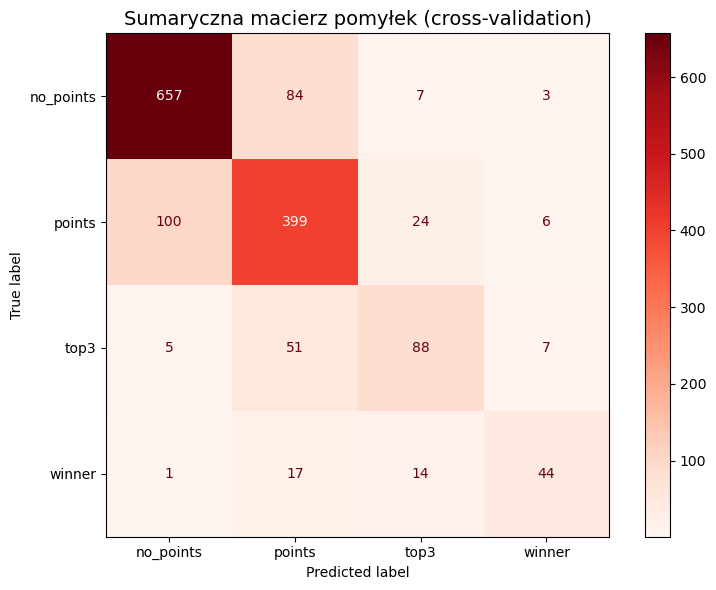

In [82]:
show_confusion_matrix(study)

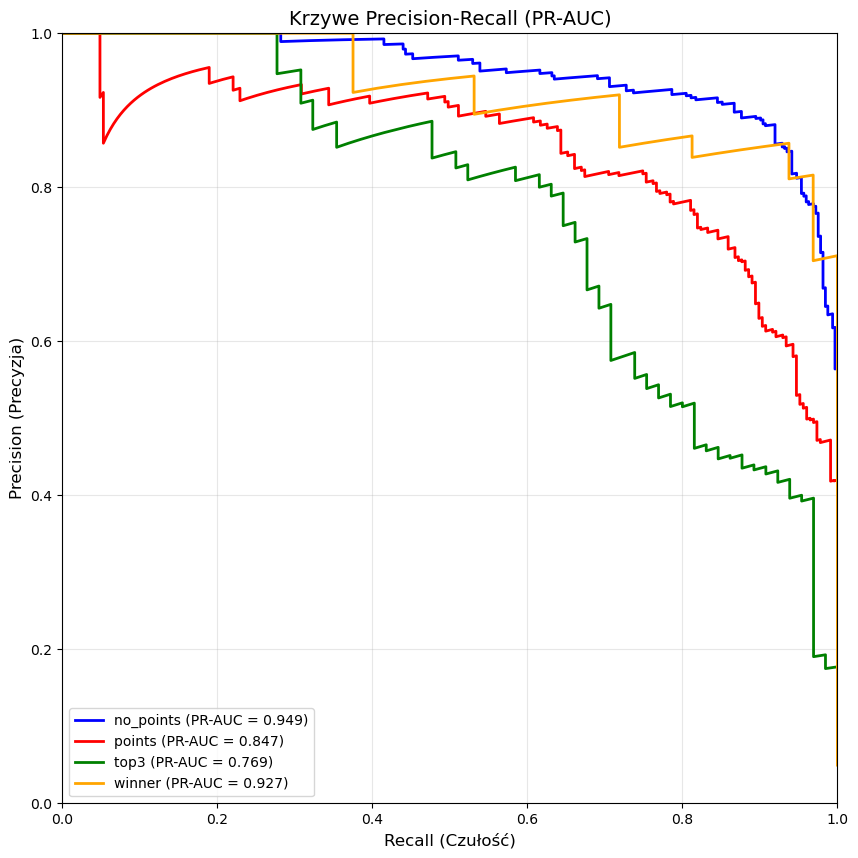

In [92]:
show_pr_auc_plot(study, X_train, y_train, X_valid, y_valid)

In [94]:
def show_feature_importance(study, X_train, y_train, feature_names):
    """Funkcja do wyświetlania ważności cech dla najlepszego modelu"""
    best_trial = study.best_trial
    best_params = best_trial.params
    
    # Tworzenie najlepszego modelu
    best_ensemble = get_best_ensemble(best_params)
    
    # Enkodowanie etykiet
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    
    # Trenowanie modelu
    best_ensemble.fit(X_train, y_train_enc)
    
    # Zbieranie ważności cech z każdego klasyfikatora
    rf_importance = best_ensemble.estimators_[0].feature_importances_  # Random Forest
    gb_importance = best_ensemble.estimators_[1].feature_importances_  # Gradient Boosting
    
    # SVM nie ma feature_importances_, więc pomijamy go lub używamy coefficients dla linear kernel
    
    # Średnia ważność z RF i GB
    avg_importance = (rf_importance + gb_importance) / 2
    
    # Tworzenie DataFrame dla lepszego wyświetlania
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Random_Forest': rf_importance,
        'Gradient_Boosting': gb_importance,
        'Average': avg_importance
    }).sort_values('Average', ascending=False)
    
    # Wykres ważności cech
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Średnia ważność
    plt.subplot(2, 2, 1)
    top_features = importance_df.head(15)  # Top 15 cech
    plt.barh(range(len(top_features)), top_features['Average'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Średnia ważność cechy')
    plt.title('Top 15 najważniejszych cech (średnia z RF i GB)')
    plt.gca().invert_yaxis()
    
    # Subplot 2: Random Forest
    plt.subplot(2, 2, 2)
    rf_top = importance_df.head(10)
    plt.barh(range(len(rf_top)), rf_top['Random_Forest'], color='green', alpha=0.7)
    plt.yticks(range(len(rf_top)), rf_top['Feature'])
    plt.xlabel('Ważność cechy (Random Forest)')
    plt.title('Top 10 cech - Random Forest')
    plt.gca().invert_yaxis()
    
    # Subplot 3: Gradient Boosting
    plt.subplot(2, 2, 3)
    gb_top = importance_df.head(10)
    plt.barh(range(len(gb_top)), gb_top['Gradient_Boosting'], color='orange', alpha=0.7)
    plt.yticks(range(len(gb_top)), gb_top['Feature'])
    plt.xlabel('Ważność cechy (Gradient Boosting)')
    plt.title('Top 10 cech - Gradient Boosting')
    plt.gca().invert_yaxis()
    
    # Subplot 4: Porównanie top 5 cech
    plt.subplot(2, 2, 4)
    top5 = importance_df.head(5)
    x = np.arange(len(top5))
    width = 0.35
    
    plt.bar(x - width/2, top5['Random_Forest'], width, label='Random Forest', color='green', alpha=0.7)
    plt.bar(x + width/2, top5['Gradient_Boosting'], width, label='Gradient Boosting', color='orange', alpha=0.7)
    
    plt.xlabel('Cechy')
    plt.ylabel('Ważność')
    plt.title('Porównanie top 5 cech')
    plt.xticks(x, top5['Feature'], rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Wyświetlenie tabeli z ważnościami
    print("\n📈 Top 20 najważniejszych cech:")
    print(importance_df.head(20).round(4))
    
    return importance_df

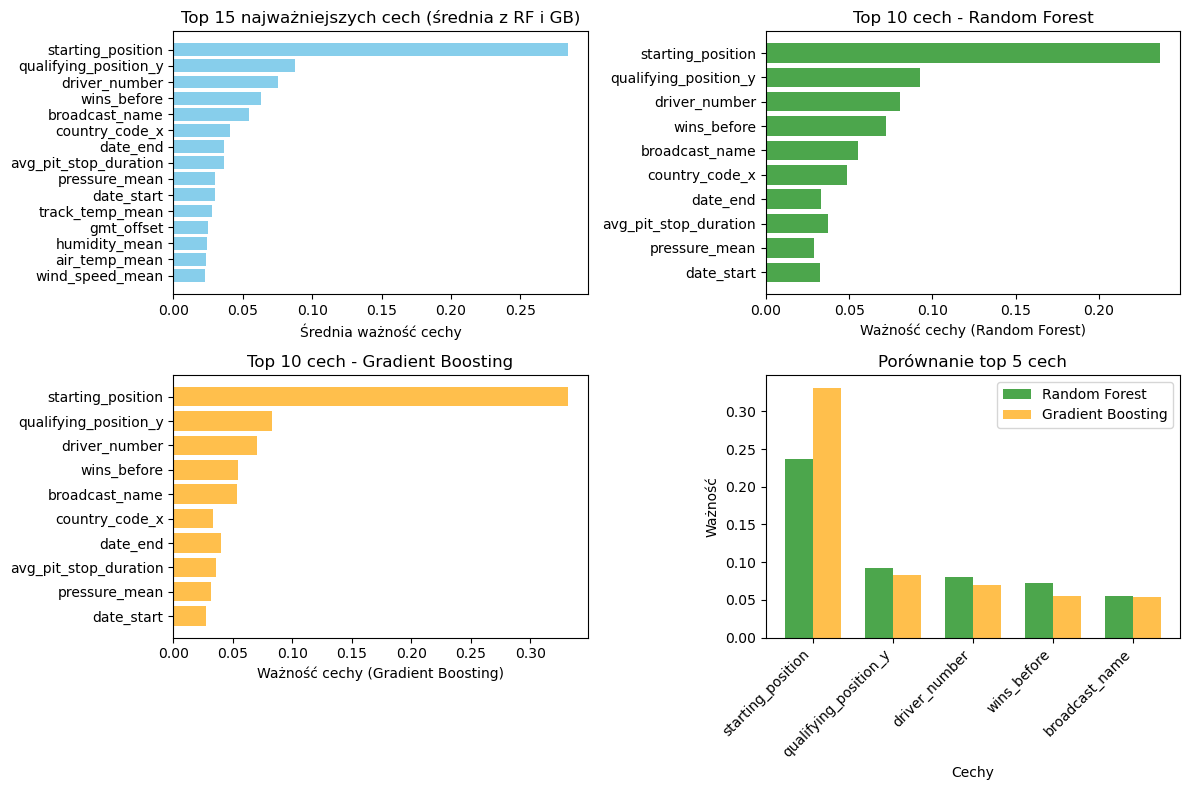


📈 Top 20 najważniejszych cech:
                    Feature  Random_Forest  Gradient_Boosting  Average
10        starting_position         0.2368             0.3315   0.2841
14    qualifying_position_y         0.0923             0.0828   0.0875
0             driver_number         0.0805             0.0701   0.0753
11              wins_before         0.0722             0.0546   0.0634
1            broadcast_name         0.0551             0.0534   0.0543
2            country_code_x         0.0490             0.0333   0.0411
7                  date_end         0.0328             0.0403   0.0366
13    avg_pit_stop_duration         0.0370             0.0358   0.0364
27            pressure_mean         0.0291             0.0316   0.0303
5                date_start         0.0325             0.0275   0.0300
25          track_temp_mean         0.0294             0.0268   0.0281
9                gmt_offset         0.0208             0.0289   0.0249
26            humidity_mean         0.0248   

In [95]:
feature_importance_df = show_feature_importance(study, X_train, y_train, X_train.columns.tolist())